In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
 print(tf.__version__ )

2.5.0


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=70

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "taiwan",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4976 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names
class_names

['Bacterial spot',
 'Black mold',
 'Gray spot',
 'Late blight',
 'health',
 'powdery mildew']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 4 1 2 5 3 4 2 0 2 1 0 3 0 5 3 4 0 2 0 0 4 3 3 2 2 0 0 0 2 3 2]


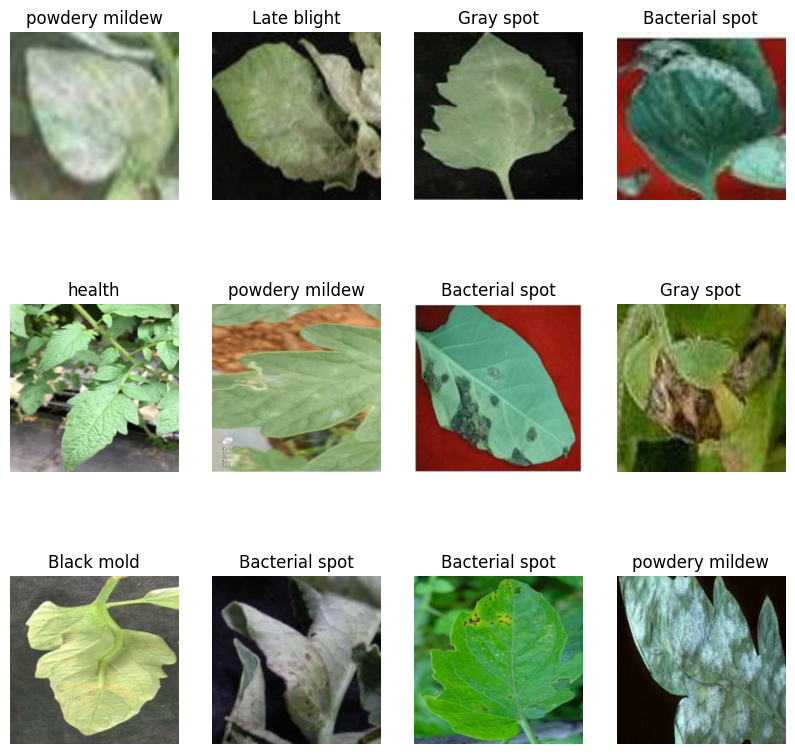

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

156

In [9]:
train_size = 0.8
len(dataset)*train_size

124.80000000000001

In [10]:
train_ds = dataset.take(124)
len(train_ds)

124

In [11]:
test_ds = dataset.skip(124)
len(test_ds)

32

In [12]:
val_size=0.1
len(dataset)*val_size

15.600000000000001

In [13]:
val_ds = test_ds.take(15)
len(val_ds)

15

In [14]:
test_ds = test_ds.skip(15)
len(test_ds)

17

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [17]:
len(train_ds)

124

In [18]:
len(val_ds)

15

In [19]:
len(test_ds)

17

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
)

Epoch 1/70
124/124 [==============================] - 221s 2s/step - loss: 1.7551 - accuracy: 0.2417 - val_loss: 1.7293 - val_accuracy: 0.2833
Epoch 2/70
124/124 [==============================] - 198s 2s/step - loss: 1.6123 - accuracy: 0.3231 - val_loss: 1.5864 - val_accuracy: 0.3979
Epoch 3/70
124/124 [==============================] - 199s 2s/step - loss: 1.4517 - accuracy: 0.4216 - val_loss: 1.3402 - val_accuracy: 0.4458
Epoch 4/70
124/124 [==============================] - 199s 2s/step - loss: 1.3076 - accuracy: 0.4929 - val_loss: 1.2821 - val_accuracy: 0.4667
Epoch 5/70
124/124 [==============================] - 200s 2s/step - loss: 1.2555 - accuracy: 0.5252 - val_loss: 1.1877 - val_accuracy: 0.5604
Epoch 6/70
124/124 [==============================] - 201s 2s/step - loss: 1.1383 - accuracy: 0.5665 - val_loss: 1.1019 - val_accuracy: 0.5583
Epoch 7/70
124/124 [==============================] - 202s 2s/step - loss: 1.1002 - accuracy: 0.5822 - val_loss: 1.0734 - val_accuracy: 0.5792

Epoch 58/70
124/124 [==============================] - 205s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.0761 - val_accuracy: 0.8458
Epoch 59/70
124/124 [==============================] - 213s 2s/step - loss: 7.9188e-04 - accuracy: 1.0000 - val_loss: 1.1053 - val_accuracy: 0.8479
Epoch 60/70
124/124 [==============================] - 213s 2s/step - loss: 6.3287e-04 - accuracy: 1.0000 - val_loss: 1.1280 - val_accuracy: 0.8479
Epoch 61/70
124/124 [==============================] - 269s 2s/step - loss: 5.0836e-04 - accuracy: 1.0000 - val_loss: 1.1416 - val_accuracy: 0.8542
Epoch 62/70
124/124 [==============================] - 258s 2s/step - loss: 4.1820e-04 - accuracy: 1.0000 - val_loss: 1.1705 - val_accuracy: 0.8479
Epoch 63/70
124/124 [==============================] - 246s 2s/step - loss: 3.4869e-04 - accuracy: 1.0000 - val_loss: 1.1843 - val_accuracy: 0.8500
Epoch 64/70
124/124 [==============================] - 247s 2s/step - loss: 2.9974e-04 - accuracy: 1.0000 - val_loss

In [27]:
scores = model.evaluate(test_ds)


17/17 [==============================] - 10s 347ms/step - loss: 1.5469 - accuracy: 0.8333


first image to predict
actual label: Bacterial spot
predicted label: Gray spot


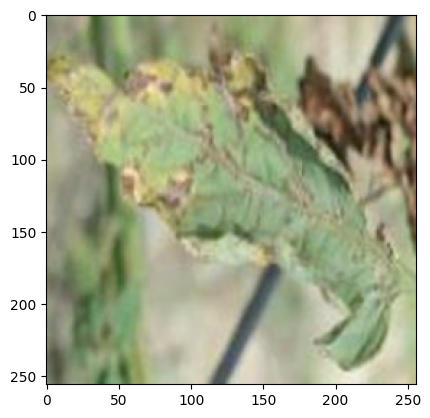

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

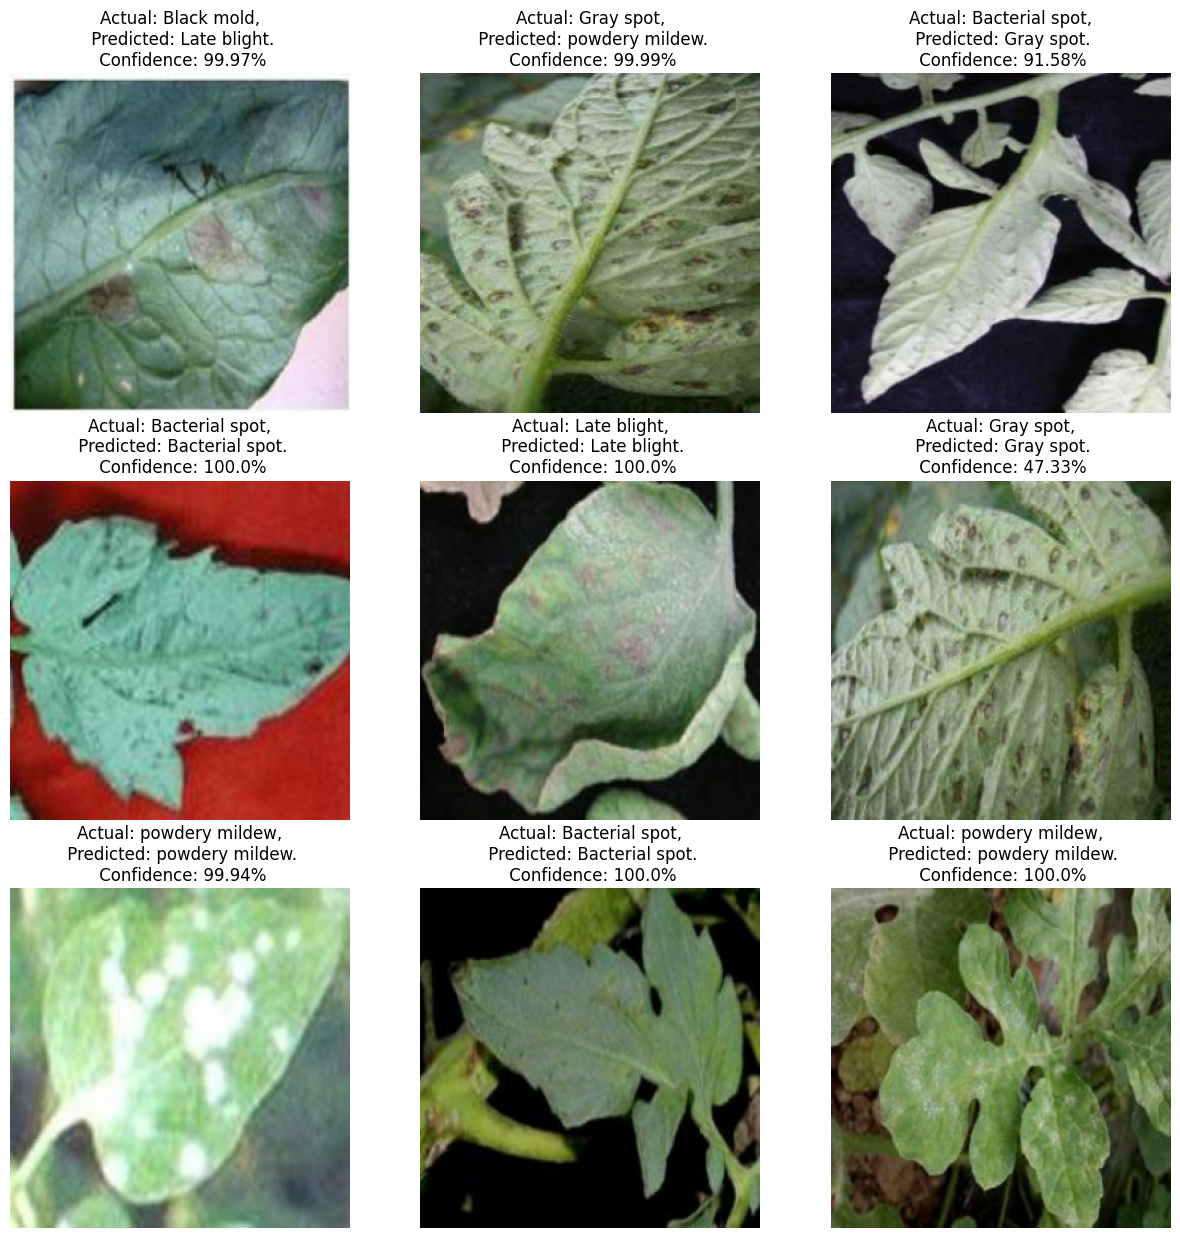

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

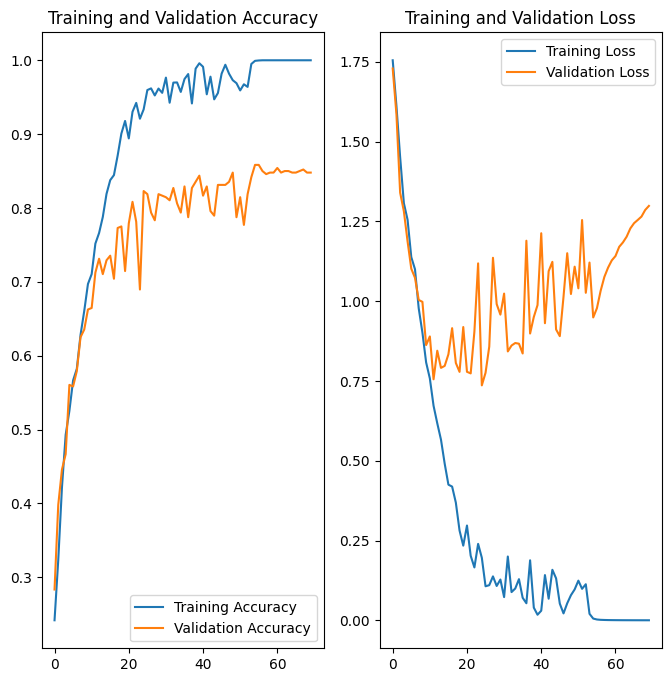

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
model_version=3
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/3\assets
